In [331]:
import numpy as np
import pandas as pd
import scipy.linalg as sla

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

## Загрузка данных

In [332]:
BGM_df = pd.read_csv('final_df_BGM.csv')

In [333]:
X = BGM_df.drop(columns=["madness", "year"]) #.values 
y = BGM_df['madness'] #.values

In [334]:
X.head()

,"(51, 49, 49)","(120, 117, 105)","(187, 163, 128)","(128, 79, 53)","(215, 208, 198)","(21, 21, 23)","(54, 73, 93)",R1,G1,B1,...,R7,G7,B7,Count7,count,line_length,straight_lines_count,straight_lines_length,circle_count,normalized_radius_sum
0,11094,641,1790,184,357,11059,1324,41,56,62,...,93,81,74,1882,2,0.078886,0.000772,19098.320525,151,0.041514
1,326,874,3297,1320,765,133,16,178,147,117,...,56,43,46,521,1,0.058533,0.000225,4216.292051,127,0.046067
2,6859,719,192,120,372,2239,439,66,72,64,...,84,59,43,350,1,0.150776,0.001736,41927.182386,176,0.047528
3,5679,419,1154,591,29,4666,473,44,50,53,...,121,77,57,299,1,0.141838,0.001411,36577.024363,130,0.047107
4,2894,483,476,1456,23,1693,16,65,61,53,...,143,83,37,767,1,0.120445,0.000980,22464.292472,193,0.046078


In [335]:
y.head()

0    0.020408
1    0.040816
2    0.061224
3    0.081633
4    0.102041
Name: madness, dtype: float64

In [336]:
X.shape, y.shape

((49, 41), (49,))

In [337]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (51, 49, 49)           49 non-null     int64  
 1   (120, 117, 105)        49 non-null     int64  
 2   (187, 163, 128)        49 non-null     int64  
 3   (128, 79, 53)          49 non-null     int64  
 4   (215, 208, 198)        49 non-null     int64  
 5   (21, 21, 23)           49 non-null     int64  
 6   (54, 73, 93)           49 non-null     int64  
 7   R1                     49 non-null     int64  
 8   G1                     49 non-null     int64  
 9   B1                     49 non-null     int64  
 10  Count1                 49 non-null     int64  
 11  R2                     49 non-null     int64  
 12  G2                     49 non-null     int64  
 13  B2                     49 non-null     int64  
 14  Count2                 49 non-null     int64  
 15  R3      

In [338]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 49 entries, 0 to 48
Series name: madness
Non-Null Count  Dtype  
--------------  -----  
49 non-null     float64
dtypes: float64(1)
memory usage: 520.0 bytes


## Обработка данных

#### Проверка на мультиколлинеарность:

In [339]:
corr_matrix = X.corr()

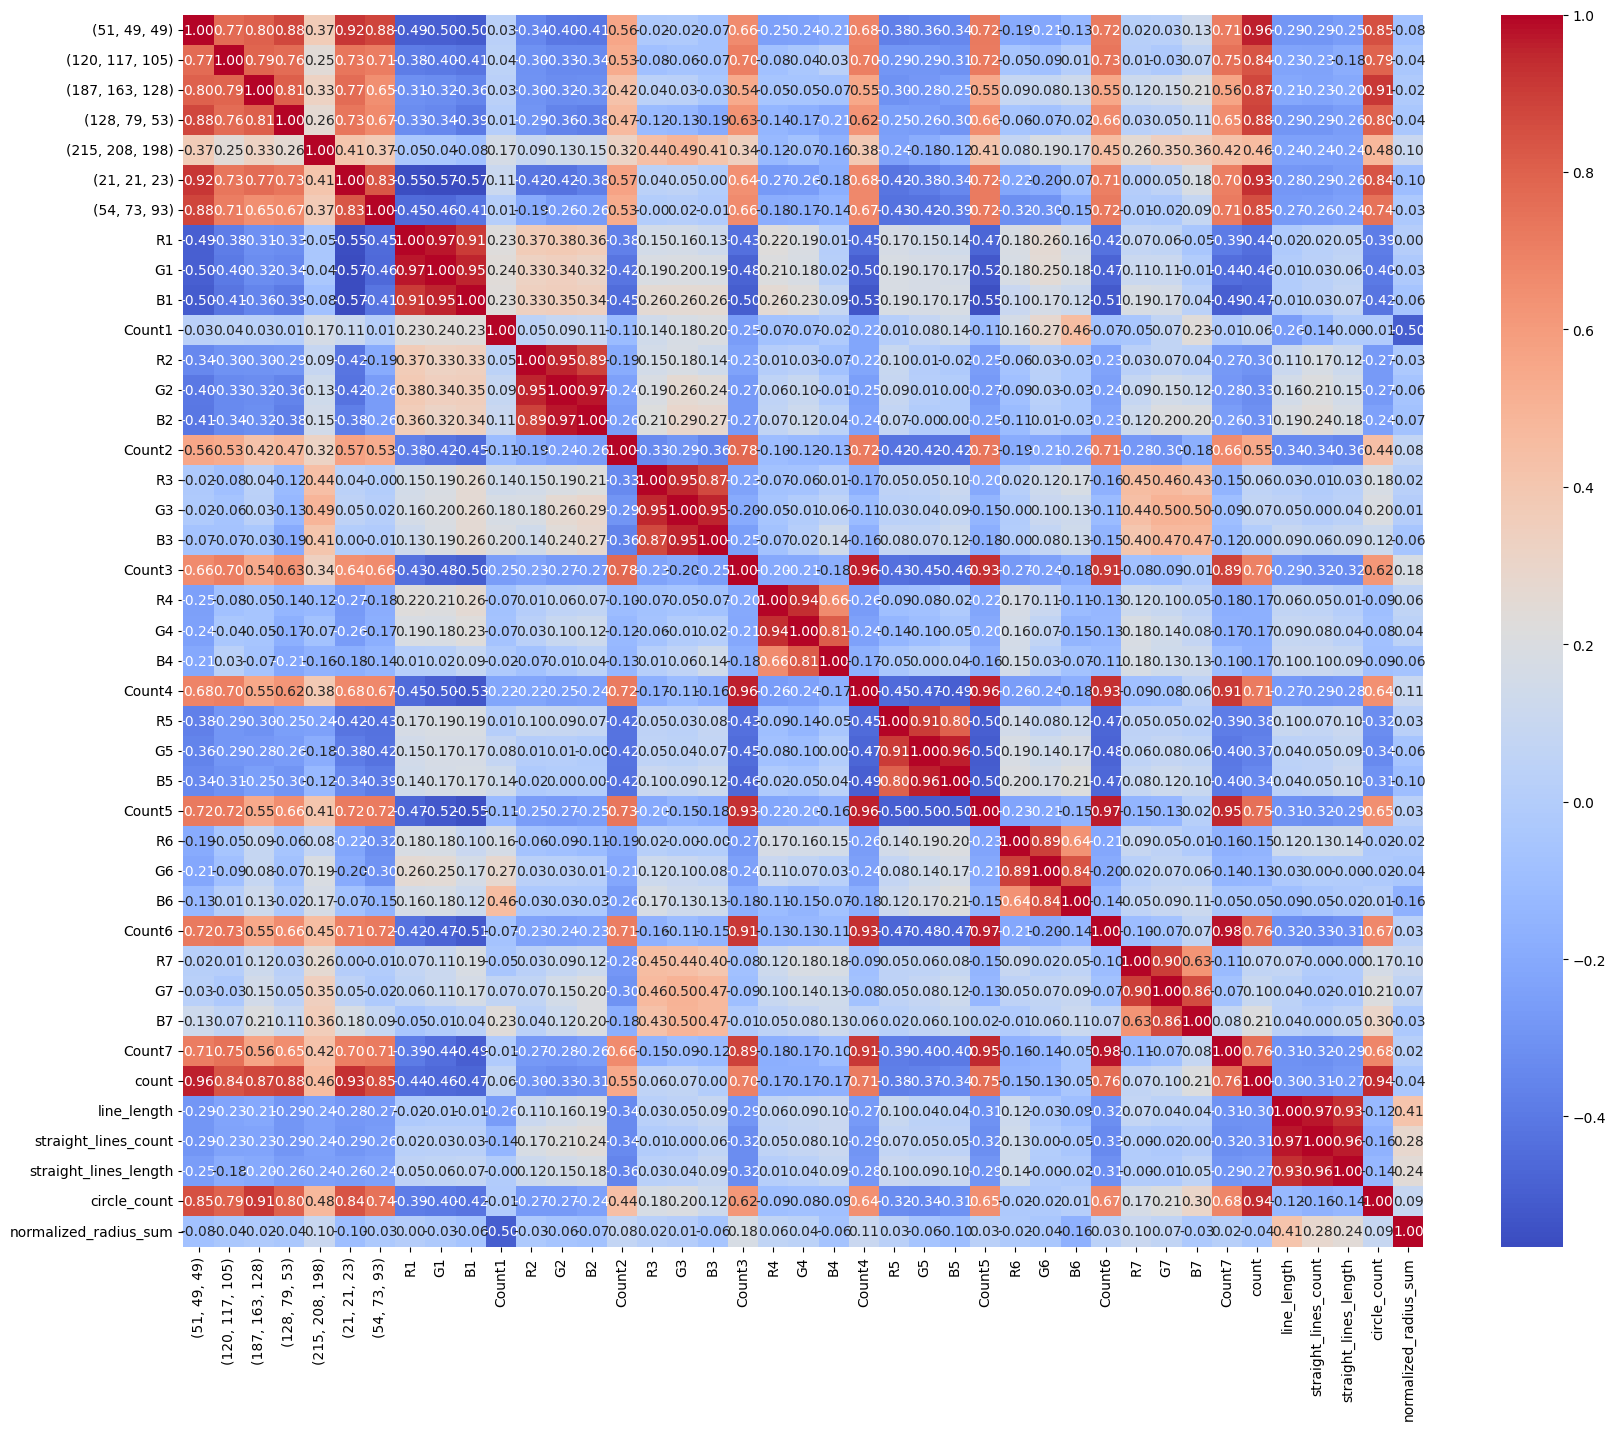

In [340]:
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.show()

In [341]:
X.corrwith(y)

(51, 49, 49)            -0.373609
(120, 117, 105)         -0.319278
(187, 163, 128)         -0.265178
(128, 79, 53)           -0.297925
(215, 208, 198)          0.191066
(21, 21, 23)            -0.353749
(54, 73, 93)            -0.312290
R1                       0.385928
G1                       0.407036
B1                       0.426892
Count1                  -0.056122
R2                       0.383877
G2                       0.391879
B2                       0.411916
Count2                  -0.380628
R3                       0.330250
G3                       0.306579
B3                       0.314116
Count3                  -0.267514
R4                       0.067819
G4                       0.099315
B4                       0.070813
Count4                  -0.251531
R5                       0.185351
G5                       0.095005
B5                       0.082304
Count5                  -0.332271
R6                       0.167332
G6                       0.135704
B6            

Удаляем все, что с отрицательной корреляцией.

In [342]:
X.drop(columns=[
    '(51, 49, 49)',
    '(120, 117, 105)',
    '(187, 163, 128)',
    '(128, 79, 53)',
    '(21, 21, 23)',
    '(54, 73, 93)',
    'Count1', 'Count2', 'Count3',
    'Count4', 'Count5', 'Count6',
    'Count7', 'count', 'circle_count'
], inplace=True)

In [343]:
corr_matrix = X.corr()

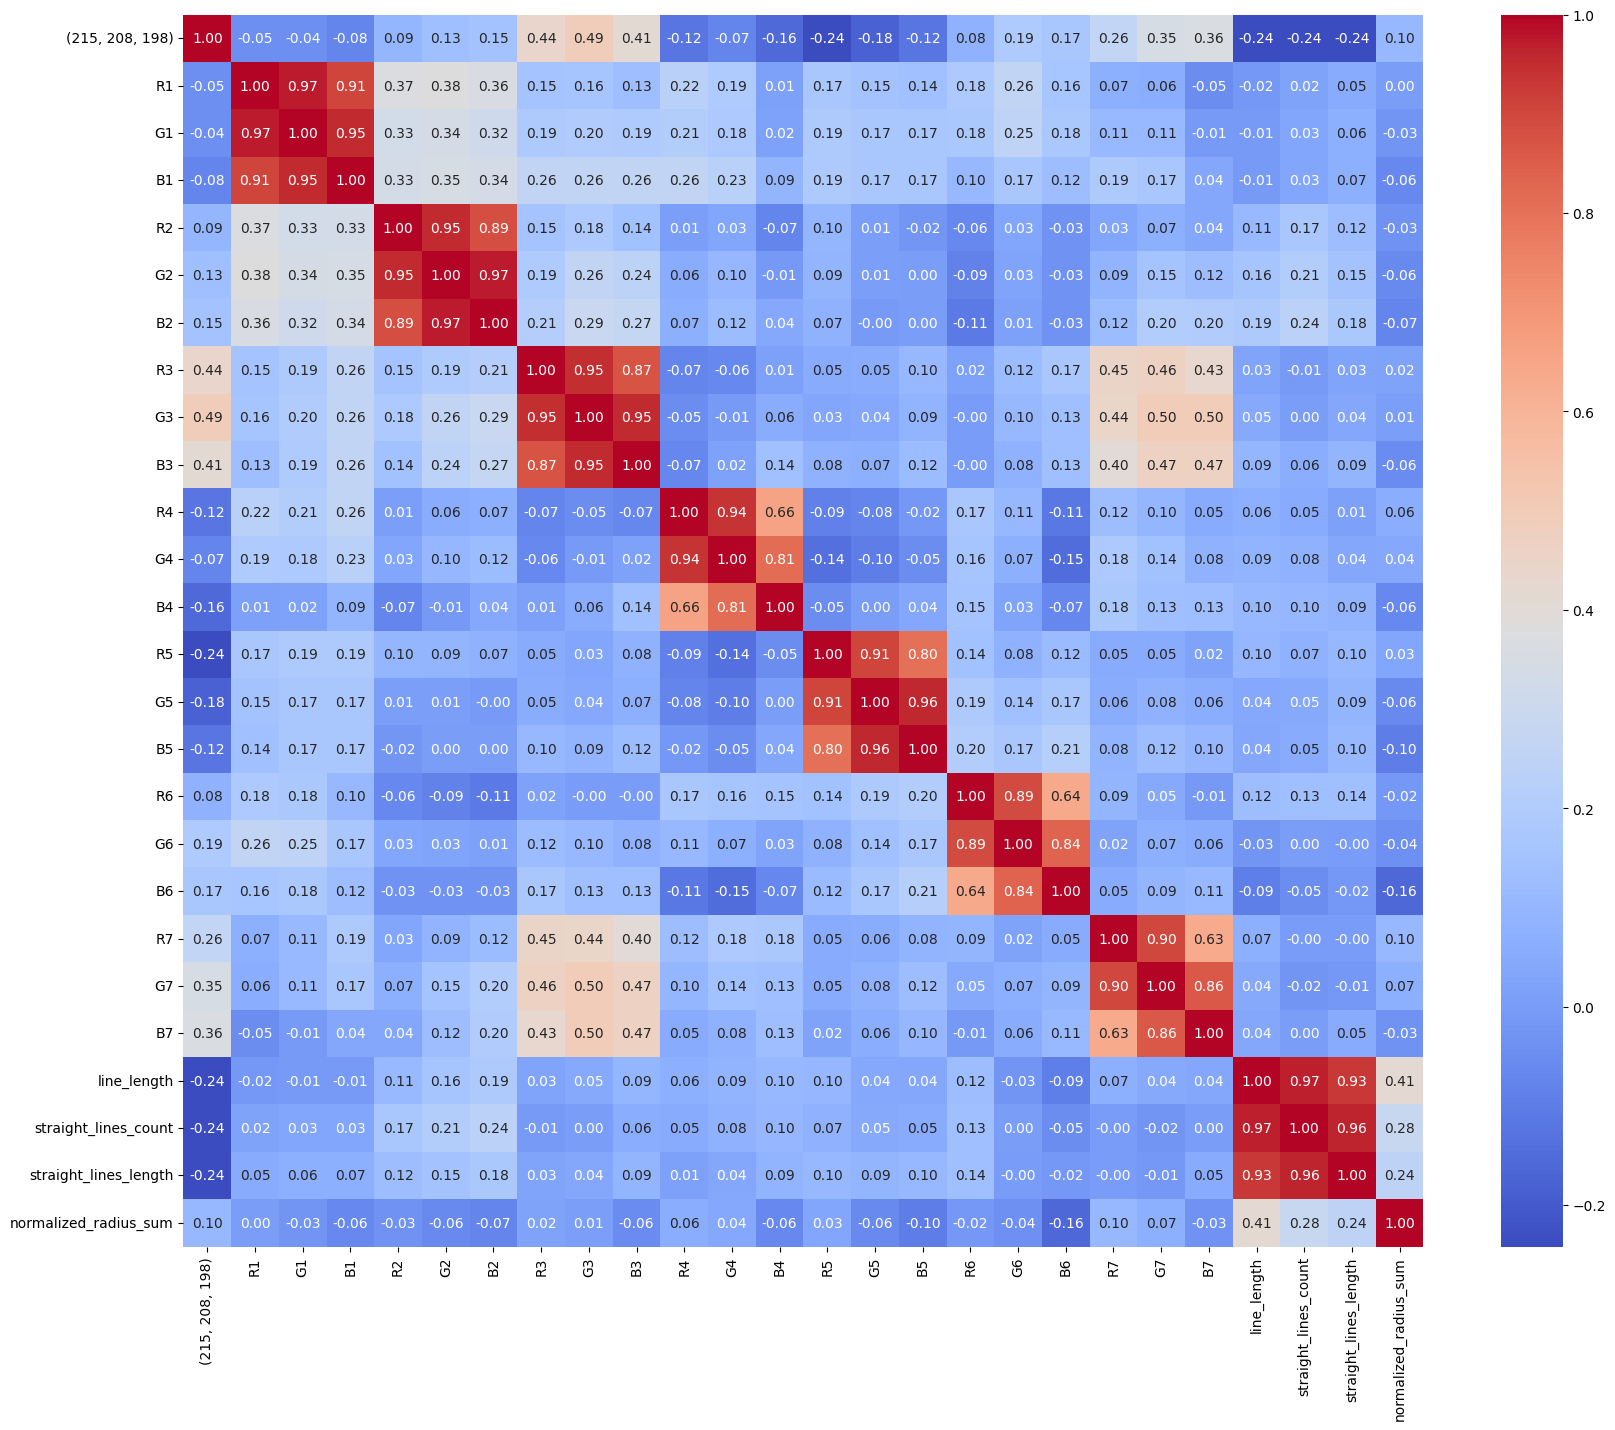

In [344]:
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.show()

In [345]:
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                    for i in range(X_const.shape[1])]

print(vif_data)

                  feature         VIF
0                   const  526.462812
1         (215, 208, 198)    3.260800
2                      R1   53.107859
3                      G1  132.242646
4                      B1   39.815640
5                      R2   40.022069
6                      G2  207.009515
7                      B2  103.993032
8                      R3   19.279201
9                      G3   66.395075
10                     B3   27.977726
11                     R4   27.606235
12                     G4   40.603799
13                     B4    8.067228
14                     R5   17.137184
15                     G5   71.669424
16                     B5   33.745525
17                     R6   21.488216
18                     G6   41.606036
19                     B6   10.145208
20                     R7   17.456506
21                     G7   39.593915
22                     B7   15.526123
23            line_length   58.532834
24   straight_lines_count   84.022229
25  straight

In [346]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

In [347]:
vif_info = calculate_vif(X)
# vif_info
high_vif = vif_info[vif_info['VIF'] > 200]  # порог
# high_vif
X = X.drop(columns=high_vif['feature'])

In [348]:
X.head()

,"(215, 208, 198)",B1,R2,R3,B3,R4,B4,R5,B5,R6,B6,R7,B7,straight_lines_length,normalized_radius_sum
0,357,62,12,45,31,63,72,22,22,195,125,93,74,19098.320525,0.041514
1,765,117,137,99,67,153,123,224,198,195,122,56,46,4216.292051,0.046067
2,372,64,42,30,45,147,142,198,176,137,99,84,43,41927.182386,0.047528
3,29,53,50,122,77,25,19,180,128,146,147,121,57,36577.024363,0.047107
4,23,53,113,134,52,196,99,37,34,178,87,143,37,22464.292472,0.046078


#### Нормализация

In [349]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [350]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [351]:
print(f"Форма до PCA: {X_scaled.shape}")
print(f"Форма после PCA: {X_pca.shape}")

Форма до PCA: (49, 15)
Форма после PCA: (49, 11)


In [352]:
explained = np.cumsum(pca.explained_variance_ratio_)

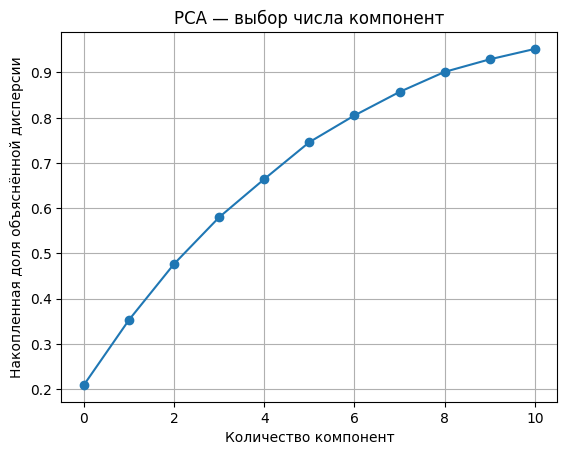

In [353]:
plt.plot(explained, marker='o')
plt.xlabel("Количество компонент")
plt.ylabel("Накопленная доля объяснённой дисперсии")
plt.title("PCA — выбор числа компонент")
plt.grid()
plt.show()

## Построение линейной регрессии

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=True)

### Scikit-learn

In [355]:
class MyLinearRegression:
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self.scaler = StandardScaler()

    def fit(self, X, y):
        # X_scaled = self.scaler.fit_transform(X)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
        # theta_best = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y # псевдообратная матрица - mse стал 1.2934...
        self.intercept_ = theta_best[0]
        self.coef_ = theta_best[1:]

    def predict(self, X):
        # X_scaled = self.scaler.transform(X)
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - u/v

In [356]:
model = MyLinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [357]:
r2 = model.score(X_test, y_test)
print(f"Коэффициент детерминации (R^2): {r2}")

mse = mean_squared_error(y_test, y_pred)
print("MSE на тестовой выборке:", mse)

mae = np.mean(np.abs(y_test - y_pred))
print("MAE на тестовой выборке:", mae)

Коэффициент детерминации (R^2): 0.14621303756078774
MSE на тестовой выборке: 0.058264470552130354
MAE на тестовой выборке: 0.2062290583648231


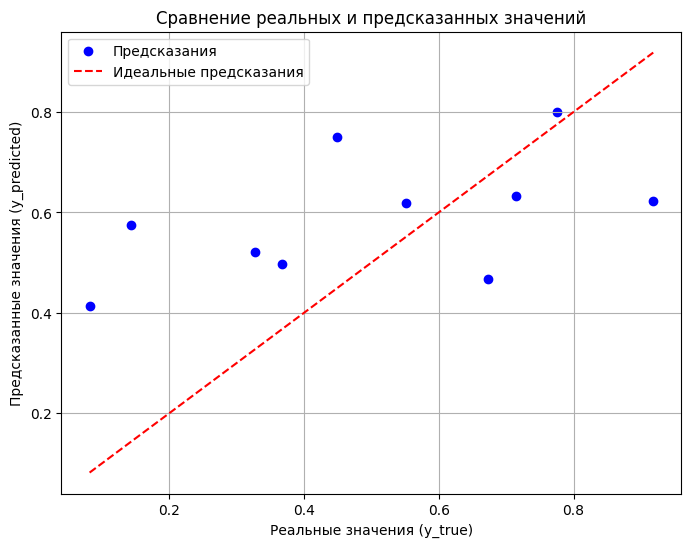

In [358]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

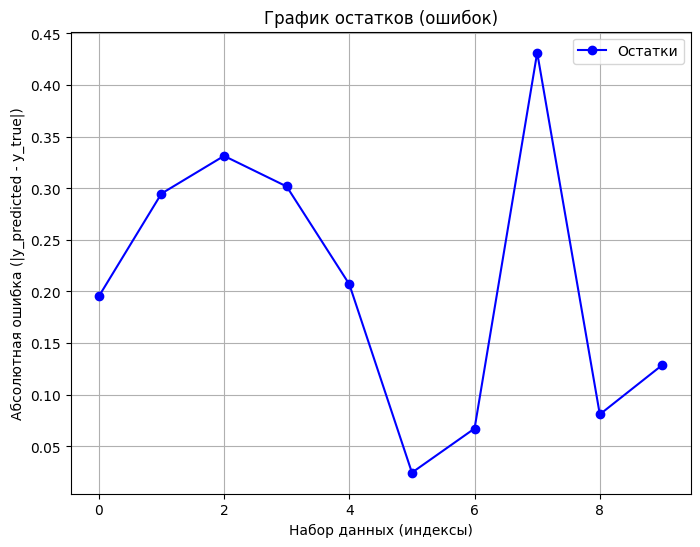

In [359]:
errors = np.abs(np.array(y_pred) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

Регрессия из sklearn:

In [360]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [361]:
print("Оценка модели на обучающих данных:")
print(f"R² (обучение): {r2_score(y_train, y_pred_train):.4f}")
print(f"MAE (обучение): {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"MSE (обучение): {mean_squared_error(y_train, y_pred_train):.4f}")

print("\nОценка модели на тестовых данных:")
print(f"R² (тест): {r2_score(y_test, y_pred_test):.4f}")
print(f"MAE (тест): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"MSE (тест): {mean_squared_error(y_test, y_pred_test):.4f}")

Оценка модели на обучающих данных:
R² (обучение): 0.4692
MAE (обучение): 0.1791
MSE (обучение): 0.0462

Оценка модели на тестовых данных:
R² (тест): 0.1462
MAE (тест): 0.2062
MSE (тест): 0.0583


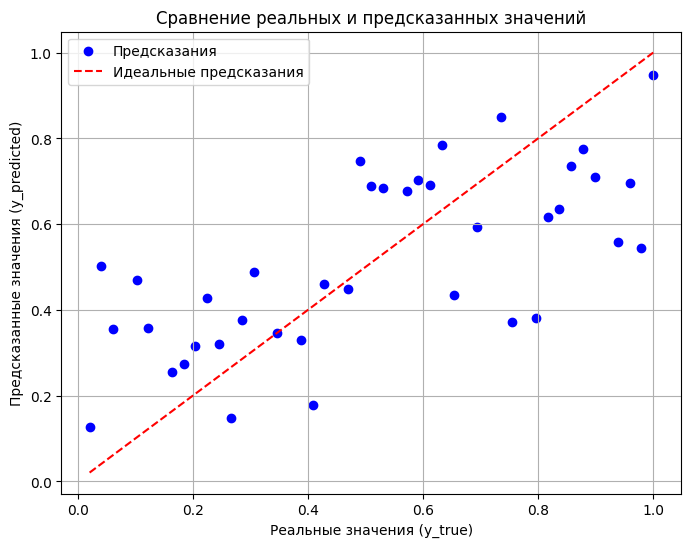

In [362]:
plt.figure(figsize=(8, 6))

plt.scatter(y_train, y_pred_train, color='blue', label='Предсказания')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

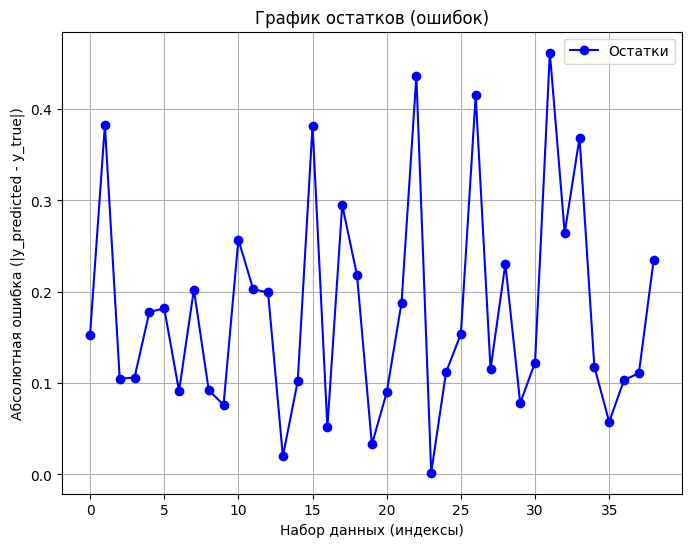

In [363]:
errors = np.abs(np.array(y_pred_train) - np.array(y_train))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

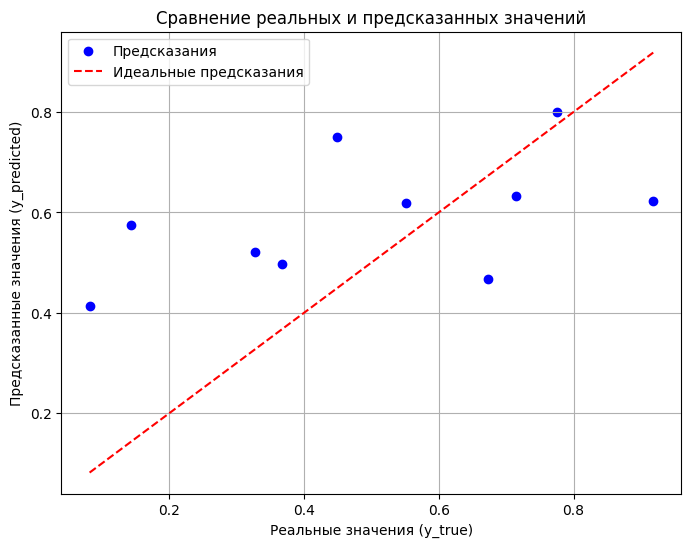

In [364]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_test, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

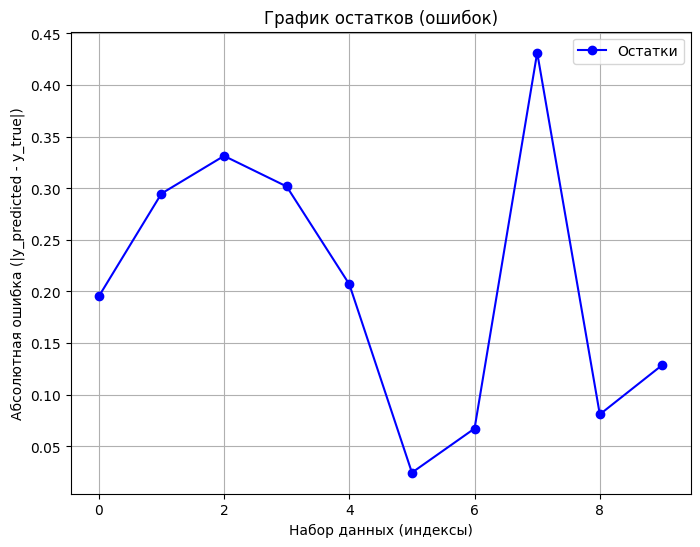

In [365]:
errors = np.abs(np.array(y_pred_test) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

Регрессия Ridge:

In [366]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

In [367]:
ridge_r2 = ridge.score(X_test, y_test)
print(f"Коэффициент детерминации (R^2) для Ridge: {ridge_r2}")

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print("Ridge MAE:", mae_ridge)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Ridge MSE:", mse_ridge)

Коэффициент детерминации (R^2) для Ridge: 0.14624583986666317
Ridge MAE: 0.20596634951291262
Ridge MSE: 0.05826223204408467


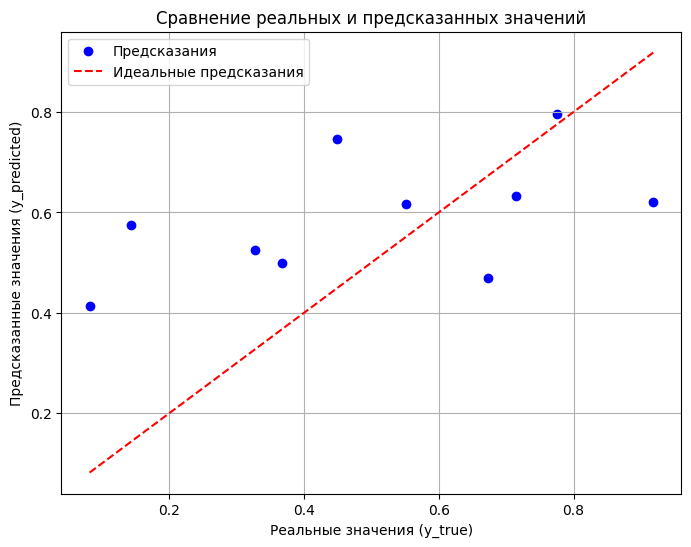

In [368]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_ridge, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

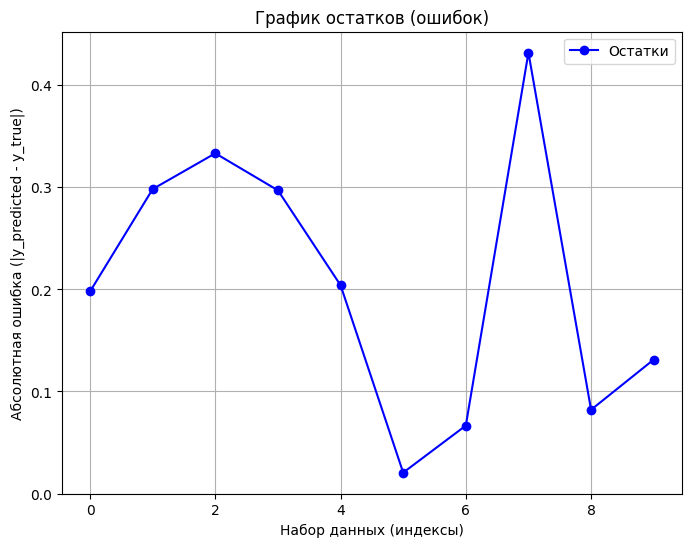

In [369]:
errors = np.abs(np.array(y_pred_ridge) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

Регрессия Lasso:

In [370]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

In [371]:
lasso_r2 = lasso.score(X_test, y_test)
print(f"Коэффициент детерминации (R^2) для Lasso: {lasso_r2}")

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print("Ridge MAE:", mae_lasso)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Ridge MSE:", mse_lasso)

Коэффициент детерминации (R^2) для Lasso: -0.05245840713376815
Ridge MAE: 0.22446453587363774
Ridge MSE: 0.07182228655096543


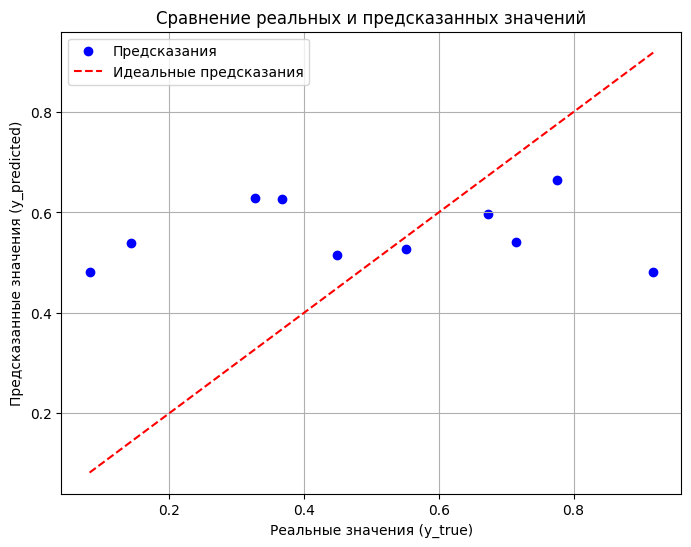

In [372]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_lasso, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

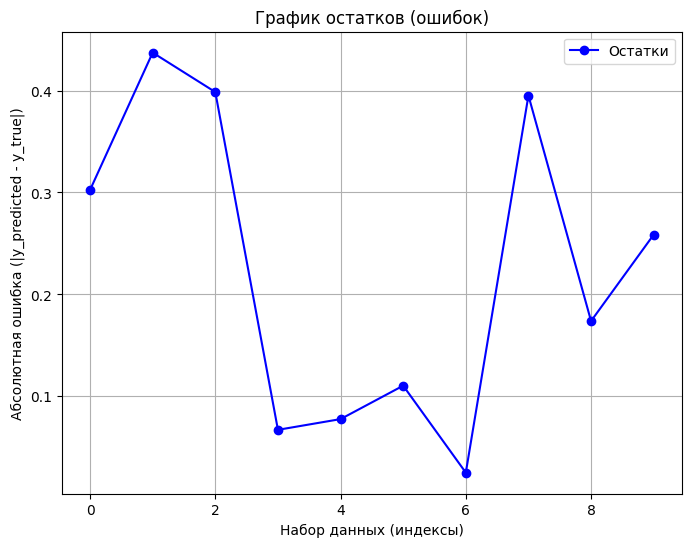

In [373]:
errors = np.abs(np.array(y_pred_lasso) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

Кросс-валидация:

In [374]:
print(X.shape)
print(y.shape)

(49, 15)
(49,)


In [375]:
scores = cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Средняя ошибка на кросс-валидации: {-scores.mean()}")

Средняя ошибка на кросс-валидации: 0.14851577303482755


### Pytorch

In [387]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [388]:
X_train_sub_tensor = torch.tensor(X_train_sub, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_sub_tensor = torch.tensor(y_train_sub.values, dtype=torch.float32).reshape(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)

In [389]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [390]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(LinearModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.layer3 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Регуляризация
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        return x

In [391]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model = LinearModel(X_train.shape[1], hidden_dim=64)
model.apply(init_weights)

LinearModel(
  (layer1): Linear(in_features=11, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [392]:
model = LinearModel(X_train.shape[1])
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2-регуляризация
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

In [393]:
class EarlyStopping:
    def __init__(self, patience=100, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [394]:
train_losses = []
val_losses = []
early_stopping = EarlyStopping(patience=100)
num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_sub_tensor)
    loss = criterion(outputs, y_train_sub_tensor)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    scheduler.step(val_loss)
    early_stopping(val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

  4%|▍         | 220/5000 [00:00<00:02, 1720.18it/s]

Epoch [100/5000], Train Loss: 0.0287, Val Loss: 0.0322
Epoch [200/5000], Train Loss: 0.0134, Val Loss: 0.0366
Early stopping triggered


In [395]:
# model.eval()
# with torch.no_grad():
#     y_pred_tensor = model(X_test_tensor)
#     y_pred = y_pred_tensor.numpy()

In [396]:
print("PyTorch R²:", r2_score(y_test, y_pred))
print("PyTorch MAE:", mean_absolute_error(y_test, y_pred))
print("PyTorch MSE:", mean_squared_error(y_test, y_pred))

PyTorch R²: 0.14621303756078774
PyTorch MAE: 0.2062290583648231
PyTorch MSE: 0.058264470552130354


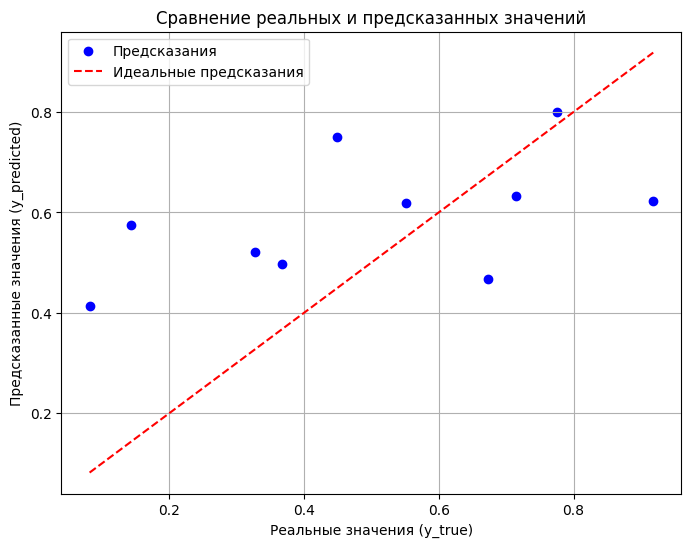

In [398]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Предсказания')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Идеальные предсказания")

plt.xlabel("Реальные значения (y_true)")
plt.ylabel("Предсказанные значения (y_predicted)")
plt.title("Сравнение реальных и предсказанных значений")
plt.legend()
plt.grid(True)
plt.show()

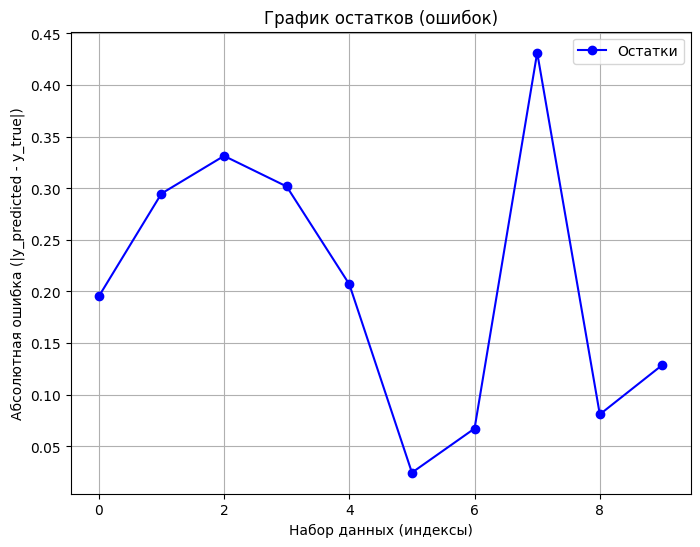

In [399]:
errors = np.abs(np.array(y_pred) - np.array(y_test))

plt.figure(figsize=(8, 6))
plt.plot(errors, marker='o', linestyle='-', color='b', label='Остатки')
plt.xlabel("Набор данных (индексы)")
plt.ylabel("Абсолютная ошибка (|y_predicted - y_true|)")
plt.title("График остатков (ошибок)")
plt.grid(True)
plt.legend()
plt.show()

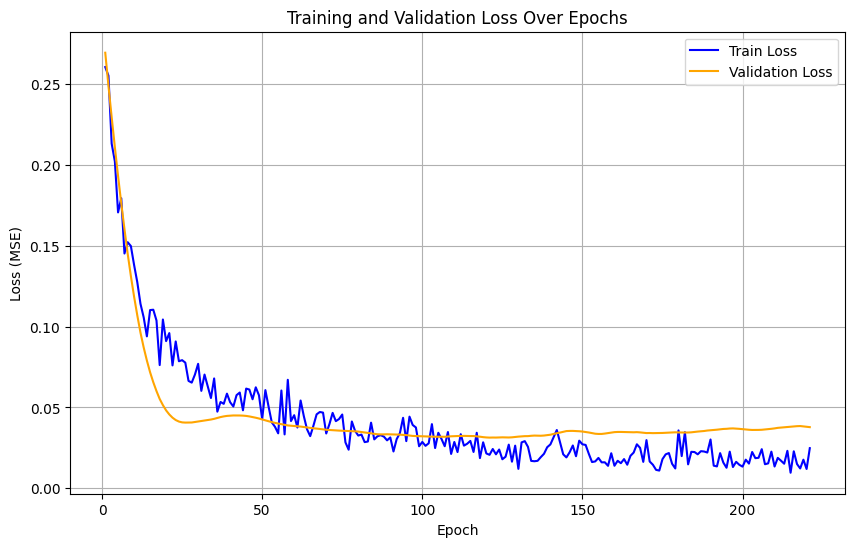

In [400]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()